In [1]:
def precision_n(n, relevant_ids_arr, sorted_ids_arr):
    union = 0
    for doc_id in sorted_ids_arr:
        if doc_id in relevant_ids_arr:
            union += 1
    return union / n

In [2]:
def average_precision_n(n, vacancies_dict, prior=None, model=None):
    total_score = 0.0
    docs_ids_arr = []
    docs_vecs_arr = []

    for name, data in vacancies_dict.items():
        docs_ids_arr += data['relevant_resumes_ids']
        docs_vecs_arr += data['relevant_resumes_vecs']
    docs_ids_arr = np.array(docs_ids_arr)
    docs_vecs_arr = np.array(docs_vecs_arr)

    for name, data in vacancies_dict.items():
#         print(name)
        vac_score = 0.0
        vacancy = data['vacancy']
        if prior is None or prior == 'Random':
            vacancy_vec = np.array(data['vacancy_vector'])[None, :]
        elif prior == 'Linear':
            vacancy_vec = model(torch.tensor(data['vacancy_vector'])).detach().numpy()[None, :]
        elif prior == 'Diffusion':
#             vacancy_vecs = []
#             for i in range(5):
#                 vacancy_vec = model.my_sample(torch.tensor(data['vacancy_vector']).unsqueeze(0).to(device)).cpu().squeeze(0).detach().numpy()[None, :]
#                 vacancy_vecs.append(vacancy_vec)
#             vacancy_vecs = np.concatenate(vacancy_vecs, axis=0)
#             vacancy_vec = np.mean(vacancy_vecs, axis=0)[None, :]
            vacancy_vec = model.my_sample(torch.tensor(data['vacancy_vector']).unsqueeze(0).to(device)).cpu().squeeze(0).detach().numpy()[None, :]
        
        resumes_ids_arr = data['relevant_resumes_ids']
        resumes_vecs_arr = np.array(data['relevant_resumes_vecs'])
        scores_arr = cosine_similarity(vacancy_vec, docs_vecs_arr)
        sorted_indices = np.argsort(scores_arr)[0][::-1]
        if prior == 'Random':
            sorted_indices = np.random.choice(scores_arr.shape[1], scores_arr.shape[1])
        output_arr = docs_ids_arr[sorted_indices[:n]]
#         print(resumes_ids_arr)
#         print(output_arr)

        for k in range(1, n + 1):
            if k <= len(output_arr) and output_arr[k - 1] in resumes_ids_arr:
                precision = precision_n(k, resumes_ids_arr, output_arr[:k])
                vac_score += precision
        vac_score /= len(resumes_ids_arr)
        total_score += vac_score
    return total_score / len(vacancies_dict.keys())

In [3]:
import numpy as np
np.set_printoptions(precision=4)
import torch
import os
import re
from sklearn.metrics.pairwise import cosine_similarity
import json

In [43]:
vacancies_dict = dict()
with open('/kaggle/input/acdlabs-vacancies/acdlabs_dict', 'r', encoding='utf-8') as file:
    vacancies_dict = json.load(file)

In [44]:
vacancies_dict.keys()

dict_keys(['Специалист службы технической поддержки (Химик)', 'english_teacher', 'Angular Frontend Developer', 'Специалист по внедрению ПО  Implementation Specialist', 'QA Automation Engineer', 'Python Developer', 'web_tester_chemist', 'po_tester', 'Tester Web Chemist New', 'web_tester', 'java_developer', 'Senior DevOps Engineer', 'Tester Web New', 'Системный администратор', 'Программист Delphi', 'Java Developer New'])

In [45]:
average_precision_n(1, vacancies_dict)

0.15600625885552355

In [46]:
average_precision_n(2, vacancies_dict)

0.3120125177110471

In [47]:
average_precision_n(3, vacancies_dict)

0.3773937765665707

In [48]:
average_precision_n(4, vacancies_dict)

0.4235042020887609

In [49]:
average_precision_n(5, vacancies_dict)

0.4764896276109511

In [50]:
average_precision_n(6, vacancies_dict)

0.5054993586886969

In [51]:
average_precision_n(7, vacancies_dict)

0.5294867683378712

## Метод MMD

MMD (Maximum Mean Discrepancy) — это мера расхождения между двумя распределениями. Идея MMD состоит в том, чтобы измерить сходство между двумя распределениями, вычисляя разницу между их средними значениями функций, называемыми ядерными функциями.

Предположим, у нас есть две выборки данных $X = \{x_1, x_2, ..., x_n\} \ и \ Y = \{y_1, y_2, ..., y_m\}$, которые мы хотим проверить на сходство. Для этого мы используем ядерные функции k(x, y), которые представляют собой меру сходства между двумя элементами данных $x \ и \ y$. MMD между этими двумя распределениями вычисляется следующим образом:

$MMD(X, Y) = \sqrt{\frac{1}{n(n-1)} \sum_{i=1}^{n} \sum_{j=1}^{n} k(x_i, x_j)} - 2 \cdot \sqrt{\frac{1}{nm} \sum_{i=1}^{n} \sum_{j=1}^{m} k(x_i, y_j)} + \sqrt{\frac{1}{m(m-1)} \sum_{i=1}^{m} \sum_{j=1}^{m} k(y_i, y_j)}$

Это выражение представляет собой разницу между средними значениями пар ядерных функций внутри каждой из выборок и средним значением пар ядерных функций между выборками. Если MMD близко к нулю, это указывает на то, что две выборки взяты из одного и того же распределения, так как их функции плотности вероятности похожи.

In [17]:
!git clone https://github.com/lucidrains/DALLE2-pytorch

Cloning into 'DALLE2-pytorch'...
remote: Enumerating objects: 2963, done.
remote: Counting objects: 100% (2963/2963), done.
remote: Compressing objects: 100% (755/755), done.
remote: Total 2963 (delta 2084), reused 2761 (delta 2033), pack-reused 0
Receiving objects: 100% (2963/2963), 3.82 MiB | 33.11 MiB/s, done.
Resolving deltas: 100% (2084/2084), done.


In [18]:
!pip install dalle2_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.2 MB/s eta 0:00:00
  Created wheel for einx: filename=einx-0.2.0-py3-none-any.whl size=87997 sha256=14181d2d88e900fecae891ee963a0755c8377897fada268891b46f6755147888
  Stored in directory: /root/.cache/pip/wheels/12/4a/44/a5ee7c1b3de3ff83d42be6383107533e069b48a326c6f28fbe
Suc

In [19]:
from sklearn.model_selection import train_test_split
import torch
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior, CLIP
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import random
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

# 100 пар (вакансия, подходящее на неё резюме)

In [20]:
csv_vacancy_path = '/kaggle/input/vacancy-resume-vectors/vacancies.csv'
csv_resume_path = '/kaggle/input/vacancy-resume-vectors/resumes.csv'

df = pd.read_csv(csv_vacancy_path, header=None)
vacancy_vectors = np.array(df.values.tolist())

df = pd.read_csv(csv_resume_path, header=None)
resume_vectors = np.array(df.values.tolist())

In [21]:
random.seed(10)
vacancy_vectors_train, vacancy_vectors_test, resume_vectors_train, resume_vectors_test = train_test_split(vacancy_vectors,
                                                                                                          resume_vectors,
                                                                                                          test_size=0.5)

In [22]:
len(vacancy_vectors_train)

389

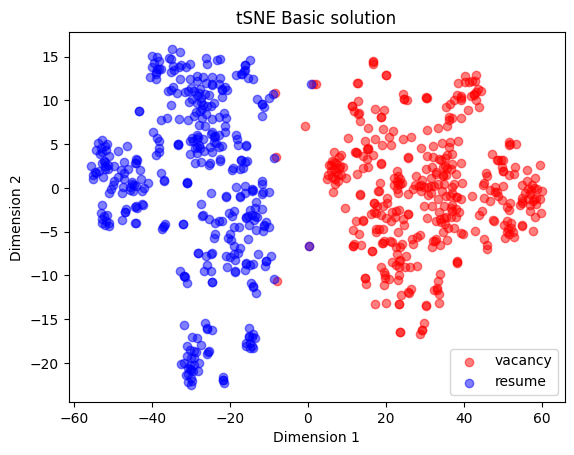

In [27]:
tsne = TSNE(n_components=2)
tsne_vectors = tsne.fit_transform(np.vstack([vacancy_vectors_test, resume_vectors_test]))
vacancy_vectors_tsne = tsne_vectors[:vacancy_vectors_test.shape[0], :]
resume_vectors_tsne = tsne_vectors[vacancy_vectors_test.shape[0]:, :]

plt.scatter(vacancy_vectors_tsne[:, 0], vacancy_vectors_tsne[:, 1], c='r', marker='o', alpha=0.5, label='vacancy')
plt.scatter(resume_vectors_tsne[:, 0], resume_vectors_tsne[:, 1], c='b', marker='o', alpha=0.5, label='resume')
plt.legend()
plt.title('tSNE Basic solution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('tSNE_Basic_solution.svg')
plt.show()

In [28]:
score = np.mean(1 - np.diag(metrics.pairwise.cosine_distances(vacancy_vectors_test, resume_vectors_test)))
print('Score: ', score)

Score:  0.9376551526735524


In [29]:
!pip install hyppo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 1.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00


In [30]:
def print_mmd(X, Y, names, funcs):
    for i, func in enumerate(funcs):
        print(names[i] + ' kernel:')
        indices = np.random.choice(min(len(X), len(Y)), min(len(X), len(Y)))
        length = len(indices) // 2
        print('Different data samples: ', func(X[indices[:length]], Y[indices[:length]]))
        print('First data sample: ', func(X[indices[:length]], X[indices[length:]]))
        print('Second data sample: ', func(Y[indices[:length]], Y[indices[length:]]))
        print('-' * 20)

In [31]:
import hyppo
from functools import partial
np.random.seed(42)
names = ['Linear', 'Rbf', 'Polynomial']
funcs = [partial(hyppo.ksample.MMD(compute_kernel='linear').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='rbf').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='polynomial').test, auto=False)]
print_mmd(vacancy_vectors_test[:-1], resume_vectors_test[:-1], names, funcs)

Linear kernel:
Different data samples:  KSampleTestOutput(stat=0.11363261428594242, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=-0.0007170237702977113, pvalue=0.977022977022977)
Second data sample:  KSampleTestOutput(stat=-0.0007292940748316062, pvalue=0.991008991008991)
--------------------
Rbf kernel:
Different data samples:  KSampleTestOutput(stat=0.11330035895205169, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=0.0005348879022371925, pvalue=0.11388611388611389)
Second data sample:  KSampleTestOutput(stat=0.00044036316501036533, pvalue=0.15184815184815184)
--------------------
Polynomial kernel:
Different data samples:  KSampleTestOutput(stat=0.11239445366717592, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=0.0008040222183620474, pvalue=0.04695304695304695)
Second data sample:  KSampleTestOutput(stat=0.0009575438996923322, pvalue=0.03496503496503497)
--------------------


In [23]:
len(resume_vectors_test)

389

## Prior

In [24]:
vacancy_vectors_train = torch.tensor(vacancy_vectors_train, dtype=torch.float32)
resume_vectors_train = torch.tensor(resume_vectors_train, dtype=torch.float32)
vacancy_vectors_test = torch.tensor(vacancy_vectors_test, dtype=torch.float32)
resume_vectors_test = torch.tensor(resume_vectors_test, dtype=torch.float32)

In [25]:
class MyPrior(torch.nn.Module):
    def __init__(self):
        super(MyPrior, self).__init__()
        self.l1 = torch.nn.Linear(1536, 1536, bias=False)
        self.l1.weight = torch.nn.Parameter(torch.eye(1536, 1536))

    def forward(self, x):
        x = self.l1(x)
        return x

In [26]:
model = MyPrior()
model.l1.weight

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], requires_grad=True)

In [27]:
def calculate_loss(Y_pred, Y):
    return torch.mean(torch.sum((Y_pred - Y)**2, dim=1))

In [28]:
@torch.no_grad()
def calculate_score(Y_pred, Y):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
    return cos(Y_pred, Y).mean()

In [29]:
def train_epoch(
    network,
    X,
    Y,
    criterion,
    optimizer,
    num_epoch
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""

    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    X, Y = X.to(device), Y.to(device)   # send data to device
    optimizer.zero_grad()   # zero out grads, collected from previous batch
    Y_pred = network(X)  # forward pass
    loss = criterion(Y_pred, Y)
    accur = calculate_score(Y_pred, Y).item()
    loss.backward()
    optimizer.step()

#     print(
#         f'Train set Epoch {num_epoch}: Loss: {loss:.4f}, Accuracy: {accur:.4f}'
#     )
    return loss.item(), accur

In [33]:
@torch.no_grad()
def val_epoch(
    network,
    X,
    Y,
    criterion,
    num_epoch
):
    """calculate loss and accuracy on validation data"""

    network.eval()  # switch network submodules to test mode
    X, Y = X.to(device), Y.to(device)
    Y_pred = network(X)
    val_loss = criterion(Y_pred, Y).item()
    val_accur = calculate_score(Y_pred, Y).item()

#     print(
#         f'Test set Epoch {num_epoch}: Loss: {val_loss:.4f}, Accuracy: {val_accur:.4f}'
#     )
#     print('-' * 30)
    return val_loss, val_accur

In [30]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    X_train,
    Y_train,
    X_test,
    Y_test
):
    """full cycle of neural network training"""
    train_loss_arr = []
    train_accur_arr = []
    val_loss_arr = []
    val_accur_arr = []

    val_loss, val_accur = val_epoch(network, X_test, Y_test, criterion, 0)
    val_loss_arr.append(val_loss)
    val_accur_arr.append(val_accur)

    train_loss_arr.append(val_loss)
    train_accur_arr.append(val_accur)

    for epoch in range(1, n_epochs + 1):
        train_loss, train_accur = train_epoch(network, X_train, Y_train, criterion, optimizer, epoch)
        train_loss_arr.append(train_loss)
        train_accur_arr.append(train_accur)

        val_loss, val_accur = val_epoch(network, X_test, Y_test, criterion, epoch)
        val_loss_arr.append(val_loss)
        val_accur_arr.append(val_accur)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(np.arange(len(train_loss_arr)), train_loss_arr, label='train')
    ax[0].plot(np.arange(len(val_loss_arr)), val_loss_arr, label='test')
    ax[0].set_title('Loss')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(np.arange(len(train_accur_arr)), train_accur_arr, label='train')
    ax[1].plot(np.arange(len(val_accur_arr)), val_accur_arr, label='test')
    ax[1].set_title('Score')
    ax[1].grid(True)
    ax[1].legend()

    plt.suptitle('Linear prior')
    plt.show()

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


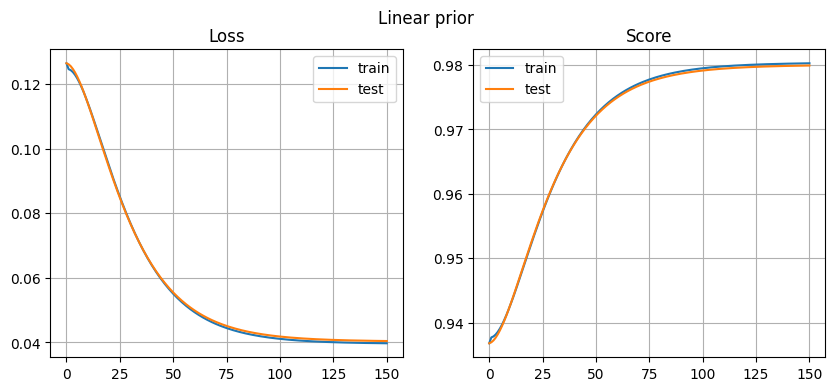

In [34]:
model = MyPrior().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
train_val(
    model,
    150,
    calculate_loss,
    optimizer,
    vacancy_vectors_test,
    resume_vectors_test,
    vacancy_vectors_train,
    resume_vectors_train,
 )

In [35]:
resume_vectors_test_pred = model(vacancy_vectors_test.to(device)).detach().cpu().numpy()

In [44]:
tsne = TSNE(n_components=2)
tsne_vectors = tsne.fit_transform(np.vstack([resume_vectors_test_pred, resume_vectors_test]))
vacancy_vectors_tsne = tsne_vectors[:resume_vectors_test_pred.shape[0], :]
resume_vectors_tsne = tsne_vectors[resume_vectors_test_pred.shape[0]:, :]

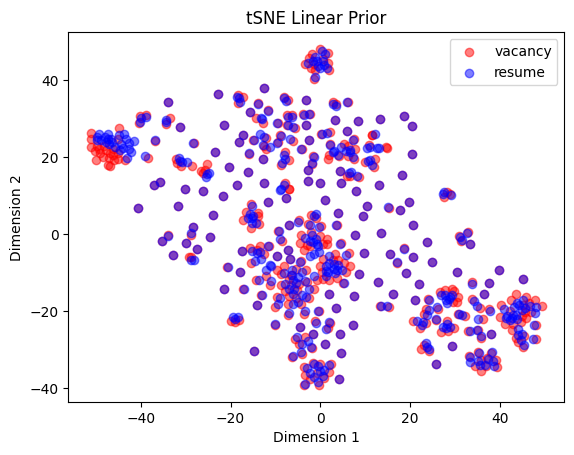

In [45]:
plt.scatter(vacancy_vectors_tsne[:, 0], vacancy_vectors_tsne[:, 1], c='r', marker='o', alpha=0.5, label='vacancy')
plt.scatter(resume_vectors_tsne[:, 0], resume_vectors_tsne[:, 1], c='b', marker='o', alpha=0.5, label='resume')
plt.legend()
plt.title('tSNE Linear Prior')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('tSNE_Linear_Prior.svg')
plt.show()

In [46]:
np.random.seed(42)
names = ['Linear', 'Rbf', 'Polynomial']
funcs = [partial(hyppo.ksample.MMD(compute_kernel='linear').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='rbf').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='polynomial').test, auto=False)]
print_mmd(resume_vectors_test_pred, resume_vectors_test.numpy(), names, funcs)

Linear kernel:
Different data samples:  KSampleTestOutput(stat=-0.0014241452875392994, pvalue=1.0)
First data sample:  KSampleTestOutput(stat=-0.0006903875109365141, pvalue=0.97002997002997)
Second data sample:  KSampleTestOutput(stat=-0.0006977884582829778, pvalue=0.981018981018981)
--------------------
Rbf kernel:
Different data samples:  KSampleTestOutput(stat=0.0002331225222486883, pvalue=0.25774225774225773)
First data sample:  KSampleTestOutput(stat=0.0007016710106426125, pvalue=0.06893106893106893)
Second data sample:  KSampleTestOutput(stat=0.0006277023035640381, pvalue=0.0989010989010989)
--------------------
Polynomial kernel:
Different data samples:  KSampleTestOutput(stat=-0.0012271596315818697, pvalue=1.0)
First data sample:  KSampleTestOutput(stat=0.0008057087826200893, pvalue=0.060939060939060936)
Second data sample:  KSampleTestOutput(stat=0.0008731621942426526, pvalue=0.04395604395604396)
--------------------


In [47]:
score = np.mean(1 - np.diag(metrics.pairwise.cosine_distances(resume_vectors_test_pred, resume_vectors_test)))
print('Linear Prior score: ', score)

Linear Prior score:  0.9805261


In [48]:
model.l1.weight @ model.l1.weight.T

tensor([[ 9.9995e-01, -2.4805e-05,  8.1361e-05,  ..., -3.8792e-05,
          7.7422e-05,  1.2707e-04],
        [-2.4805e-05,  9.9969e-01,  1.0824e-04,  ...,  1.6089e-04,
         -5.3727e-05,  8.6385e-06],
        [ 8.1361e-05,  1.0824e-04,  9.9988e-01,  ..., -1.4753e-04,
          7.4519e-05,  8.4846e-05],
        ...,
        [-3.8792e-05,  1.6089e-04, -1.4753e-04,  ...,  9.9986e-01,
         -4.5161e-05, -1.5191e-04],
        [ 7.7422e-05, -5.3727e-05,  7.4519e-05,  ..., -4.5161e-05,
          9.9988e-01,  1.0476e-04],
        [ 1.2707e-04,  8.6385e-06,  8.4846e-05,  ..., -1.5191e-04,
          1.0476e-04,  1.0001e+00]], device='cuda:0', grad_fn=<MmBackward0>)

## Evaluating

In [52]:
cpu_model = model.cpu()
average_precision_n(1, vacancies_dict, 'Linear', cpu_model)

0.15600625885552355

In [53]:
average_precision_n(2, vacancies_dict, 'Linear', cpu_model)

0.3120125177110471

In [54]:
average_precision_n(3, vacancies_dict, 'Linear', cpu_model)

0.4055187765665707

In [55]:
average_precision_n(4, vacancies_dict, 'Linear', cpu_model)

0.4625667020887609

In [56]:
average_precision_n(5, vacancies_dict, 'Linear', cpu_model)

0.4993021276109511

In [57]:
average_precision_n(6, vacancies_dict, 'Linear', cpu_model)

0.5231035253553636

In [58]:
average_precision_n(7, vacancies_dict, 'Linear', cpu_model)

0.5515552207188236

## Dalle-2 prior

In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [60]:
size = 1536

In [61]:
# setup prior network, which contains an autoregressive transformer

prior_network = DiffusionPriorNetwork(
    dim = size,
    depth = 6,
    dim_head = 64,
    heads = 8
).to(device)

In [62]:
def train_epoch(
    diffusion_prior,
    X,
    Y,
    optimizer,
    batch_size
):
    train_loss = 0
    diffusion_prior.train()
    num_batch = len(X) // batch_size
    for i in range(num_batch):
        X_train, Y_train = X[i*batch_size:(i+1)*batch_size].to(device), Y[i*batch_size:(i+1)*batch_size].to(device)
        optimizer.zero_grad()
        loss = diffusion_prior(text_embed=X_train, image_embed=Y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    return train_loss / num_batch

In [26]:
@torch.no_grad()
def val_epoch(
    diffusion_prior,
    X,
    Y,
    batch_size
):
    test_loss = 0
    diffusion_prior.eval()
    num_batch = len(X) // batch_size
    for i in range(num_batch):
        X_test, Y_test = X[i*batch_size:(i+1)*batch_size].to(device), Y[i*batch_size:(i+1)*batch_size].to(device)
        val_loss = diffusion_prior(text_embed=X_test, image_embed=Y_test).item()
        test_loss += val_loss
    return test_loss / num_batch

In [63]:
num_epochs = 50
bath_size = 16
train_loss_arr = []
test_loss_arr = []

diffusion_prior = DiffusionPrior(
    net = prior_network,
    image_embed_dim = size,
    timesteps = 100,
    cond_drop_prob = 0.2,
    condition_on_text_encodings = False
).to(device)
optimizer = torch.optim.SGD(diffusion_prior.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
min_test_loss = 0.06
for i in tqdm(range(num_epochs)):
    loss = train_epoch(diffusion_prior, vacancy_vectors_train, resume_vectors_train, optimizer, bath_size)
    train_loss_arr.append(loss)
    test_loss = val_epoch(diffusion_prior, vacancy_vectors_test, resume_vectors_test, bath_size)
    test_loss_arr.append(test_loss)
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(diffusion_prior.state_dict(), 'diffusion_prior_state.pth')
        torch.save(optimizer.state_dict(), 'diffusion_prior_optimizer_state.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

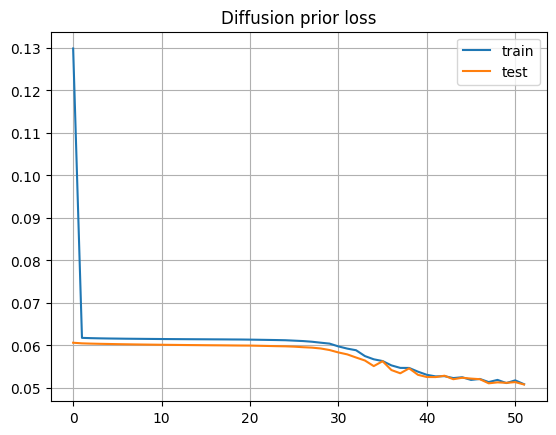

In [ ]:
plt.plot(np.arange(len(train_loss_arr)), train_loss_arr, label='train')
plt.plot(np.arange(len(test_loss_arr)), test_loss_arr, label='test')
plt.title('Diffusion prior loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
torch.save(diffusion_prior.state_dict(), 'colab_diffusion_prior_state_2.pth')

In [64]:
diffusion_prior = DiffusionPrior(
    net = prior_network,
    image_embed_dim = size,
    timesteps = 100,
    cond_drop_prob = 0.2,
    condition_on_text_encodings = False
).to(device)
diffusion_prior.load_state_dict(torch.load('/kaggle/input/prior-states/diffusion_prior_state.pth 2'))

<All keys matched successfully>

In [65]:
def exists(val):
    return val is not None

In [66]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

In [67]:
def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

In [68]:
@torch.no_grad()
@eval_decorator
def my_sample(
    self,
    text_embed,
    num_samples_per_batch = 2,
    cond_scale = 1.,
    timesteps = None
):
    timesteps = default(timesteps, self.sample_timesteps)

    batch_size = text_embed.shape[0]
    image_embed_dim = self.image_embed_dim

    text_cond = dict(text_embed = text_embed)

    image_embeds = self.p_sample_loop((batch_size, image_embed_dim), text_cond = text_cond, cond_scale = cond_scale, timesteps = timesteps)

    # retrieve original unscaled image embed
    return image_embeds

In [69]:
DiffusionPrior.my_sample = my_sample

In [34]:
resume_vectors_test_pred_lst = []
batch_size = 4
for i in tqdm(range(len(vacancy_vectors_test) // batch_size)):
    resume_vectors_test_pred_lst.append(diffusion_prior.my_sample(vacancy_vectors_test[batch_size * i:batch_size * i + batch_size].to(device)))

  0%|          | 0/97 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/97 [00:12<20:44, 12.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/97 [00:25<19:44, 12.46s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/97 [00:37<19:19, 12.34s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 4/97 [00:49<19:11, 12.38s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 5/97 [01:02<19:12, 12.53s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/97 [01:15<19:20, 12.76s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/97 [01:29<19:39, 13.10s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/97 [01:43<20:03, 13.52s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/97 [01:58<20:16, 13.82s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/97 [02:12<20:05, 13.85s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 11%|█▏        | 11/97 [02:26<19:47, 13.81s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/97 [02:39<19:33, 13.81s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/97 [02:53<19:26, 13.88s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/97 [03:08<19:19, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/97 [03:22<19:09, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▋        | 16/97 [03:36<18:55, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 17/97 [03:50<18:38, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▊        | 18/97 [04:04<18:23, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 20%|█▉        | 19/97 [04:18<18:10, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 20/97 [04:32<17:58, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 21/97 [04:46<17:47, 14.04s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 22/97 [05:00<17:33, 14.05s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▎       | 23/97 [05:14<17:19, 14.05s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▍       | 24/97 [05:28<17:05, 14.04s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 25/97 [05:42<16:50, 14.04s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 26/97 [05:56<16:35, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 27/97 [06:10<16:20, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 28/97 [06:24<16:05, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 30%|██▉       | 29/97 [06:38<15:50, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 30/97 [06:52<15:35, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 31/97 [07:06<15:21, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 32/97 [07:20<15:07, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 33/97 [07:34<14:53, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 35%|███▌      | 34/97 [07:48<14:40, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 36%|███▌      | 35/97 [08:02<14:26, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 37%|███▋      | 36/97 [08:16<14:12, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 37/97 [08:30<13:59, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 39%|███▉      | 38/97 [08:44<13:45, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 39/97 [08:58<13:31, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 41%|████      | 40/97 [09:12<13:17, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▏     | 41/97 [09:26<13:03, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 43%|████▎     | 42/97 [09:40<12:50, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 43/97 [09:54<12:36, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 45%|████▌     | 44/97 [10:08<12:22, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▋     | 45/97 [10:22<12:08, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 46/97 [10:36<11:54, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 48%|████▊     | 47/97 [10:50<11:40, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 49%|████▉     | 48/97 [11:04<11:26, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 51%|█████     | 49/97 [11:18<11:12, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 52%|█████▏    | 50/97 [11:32<10:58, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 51/97 [11:46<10:44, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 54%|█████▎    | 52/97 [12:00<10:30, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████▍    | 53/97 [12:14<10:16, 14.02s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 56%|█████▌    | 54/97 [12:28<10:02, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▋    | 55/97 [12:42<09:48, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 58%|█████▊    | 56/97 [12:56<09:34, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 57/97 [13:10<09:20, 14.01s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 60%|█████▉    | 58/97 [13:24<09:06, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 61%|██████    | 59/97 [13:38<08:52, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 62%|██████▏   | 60/97 [13:52<08:38, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 63%|██████▎   | 61/97 [14:06<08:23, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 62/97 [14:20<08:09, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 65%|██████▍   | 63/97 [14:34<07:55, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 66%|██████▌   | 64/97 [14:48<07:41, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 67%|██████▋   | 65/97 [15:02<07:27, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 66/97 [15:16<07:13, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 69%|██████▉   | 67/97 [15:30<06:59, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 68/97 [15:44<06:45, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████   | 69/97 [15:58<06:31, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 72%|███████▏  | 70/97 [16:12<06:17, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 73%|███████▎  | 71/97 [16:26<06:03, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 72/97 [16:40<05:49, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 75%|███████▌  | 73/97 [16:54<05:35, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▋  | 74/97 [17:08<05:21, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 77%|███████▋  | 75/97 [17:22<05:07, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████▊  | 76/97 [17:36<04:53, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 79%|███████▉  | 77/97 [17:49<04:39, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 78/97 [18:03<04:25, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 81%|████████▏ | 79/97 [18:17<04:11, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 80/97 [18:31<03:57, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 84%|████████▎ | 81/97 [18:45<03:43, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 85%|████████▍ | 82/97 [18:59<03:29, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 86%|████████▌ | 83/97 [19:13<03:15, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 87%|████████▋ | 84/97 [19:27<03:01, 13.96s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 85/97 [19:41<02:47, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▊ | 86/97 [19:55<02:33, 13.97s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 90%|████████▉ | 87/97 [20:09<02:19, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 91%|█████████ | 88/97 [20:23<02:05, 13.98s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 92%|█████████▏| 89/97 [20:37<01:51, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 93%|█████████▎| 90/97 [20:51<01:37, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 91/97 [21:05<01:23, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 95%|█████████▍| 92/97 [21:19<01:09, 13.99s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▌| 93/97 [21:33<00:55, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 97%|█████████▋| 94/97 [21:47<00:41, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 95/97 [22:01<00:27, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 96/97 [22:15<00:14, 14.00s/it]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 97/97 [22:29<00:00, 13.91s/it]


In [35]:
torch.vstack(resume_vectors_test_pred_lst).size()

torch.Size([388, 1536])

In [36]:
resume_vectors_test_pred = torch.vstack(resume_vectors_test_pred_lst)
vacancy_vectors_test = vacancy_vectors_test[:len(resume_vectors_test_pred)]
resume_vectors_test = resume_vectors_test[:len(resume_vectors_test_pred)]

In [ ]:
loss = val_epoch(diffusion_prior, vacancy_vectors_test.to(device), resume_vectors_test.to(device), 2)
loss

0.051080831845012525

In [ ]:
loss = val_epoch(diffusion_prior, resume_vectors_test_pred.to(device), resume_vectors_test.to(device), 2)
loss

0.0526172845941229

In [38]:
resume_vectors_test_pred = resume_vectors_test_pred.detach().cpu().numpy()

In [ ]:
tsne = TSNE(n_components=2)
tsne_vectors = tsne.fit_transform(np.vstack([resume_vectors_test_pred / np.linalg.norm(resume_vectors_test_pred, axis=1)[:, None],
                                                 resume_vectors_test / np.linalg.norm(resume_vectors_test, axis=1)[:, None]]))
vacancy_vectors_tsne = tsne_vectors[:resume_vectors_test_pred.shape[0], :]
resume_vectors_tsne = tsne_vectors[resume_vectors_test_pred.shape[0]:, :]

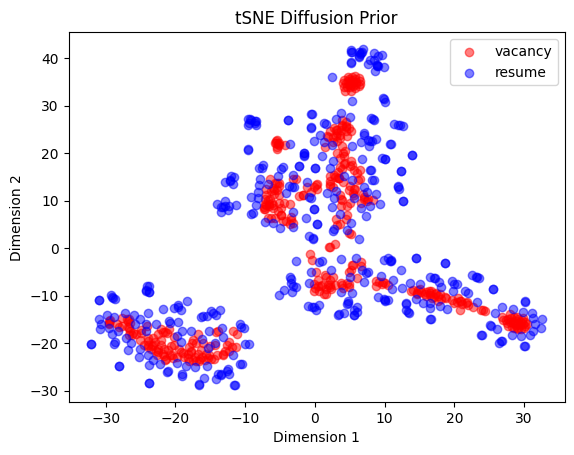

In [ ]:
plt.scatter(vacancy_vectors_tsne[:, 0], vacancy_vectors_tsne[:, 1], c='r', marker='o', alpha=0.5, label='vacancy')
plt.scatter(resume_vectors_tsne[:, 0], resume_vectors_tsne[:, 1], c='b', marker='o', alpha=0.5, label='resume')
plt.legend()
plt.title('tSNE Diffusion Prior')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('tSNE_Diffusion_Prior.svg')
plt.show()

In [39]:
score = np.mean(1 - np.diag(metrics.pairwise.cosine_distances(resume_vectors_test_pred, resume_vectors_test)))
print('Diffusion Prior Score: ', score)

Diffusion Prior Score:  0.9745358


In [45]:
np.random.seed(42)
names = ['Linear', 'Rbf', 'Polynomial']
funcs = [partial(hyppo.ksample.MMD(compute_kernel='linear').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='rbf').test, auto=False),
         partial(hyppo.ksample.MMD(compute_kernel='polynomial').test, auto=False)]
print_mmd(resume_vectors_test_pred, resume_vectors_test.numpy(), names, funcs)

Linear kernel:
Different data samples:  KSampleTestOutput(stat=0.010658337805995366, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=-0.000376369246629096, pvalue=0.8031968031968032)
Second data sample:  KSampleTestOutput(stat=-0.00035233513453503335, pvalue=0.7922077922077922)
--------------------
Rbf kernel:
Different data samples:  KSampleTestOutput(stat=0.03883037600027097, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=-3.725933381073538e-05, pvalue=0.44955044955044954)
Second data sample:  KSampleTestOutput(stat=-0.0002815636911285061, pvalue=0.7272727272727273)
--------------------
Polynomial kernel:
Different data samples:  KSampleTestOutput(stat=0.012195561421964707, pvalue=0.000999000999000999)
First data sample:  KSampleTestOutput(stat=-0.0004886097243069292, pvalue=0.977022977022977)
Second data sample:  KSampleTestOutput(stat=-4.678011991573192e-05, pvalue=0.4965034965034965)
--------------------


In [72]:
average_precision_n(1, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.03333333333333333

In [73]:
average_precision_n(2, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.05416666666666667

In [74]:
average_precision_n(3, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.05416666666666667

In [75]:
average_precision_n(4, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.06133578431372548

In [76]:
average_precision_n(5, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.06133578431372548

In [77]:
average_precision_n(6, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.06256127450980392

In [78]:
average_precision_n(7, vacancies_dict, 'Diffusion', diffusion_prior)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0.07529761904761904

In [82]:
val = 0
for i in range(10):
    val += average_precision_n(5, vacancies_dict, 'Random')
val / 10

0.018831233955314837